In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import random 
from scipy import stats
from sklearn.model_selection import train_test_split

# Regression v.s. classification

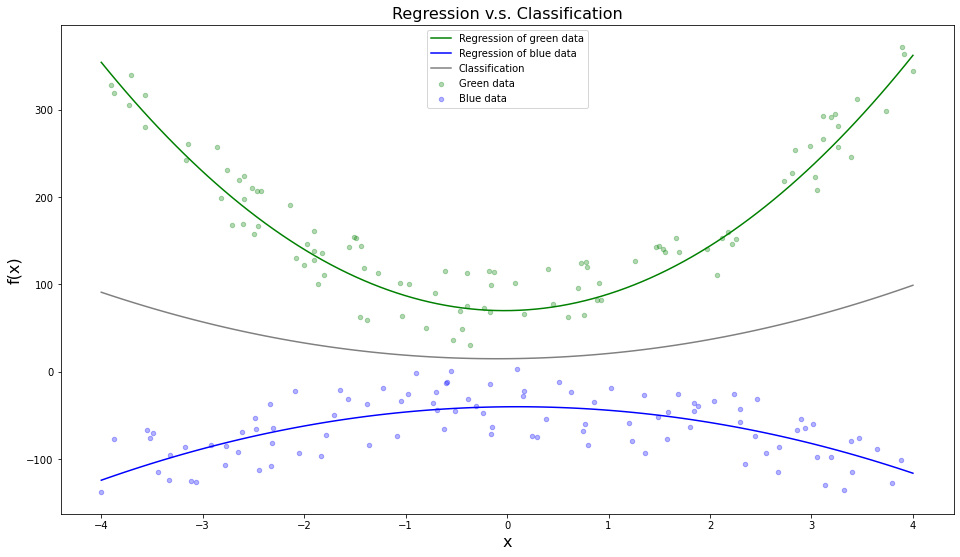

In [2]:
x = np.linspace(-4, 4, 100)
y = 5*x**2 + x + 15

x1 = np.random.uniform(-4, 4, 100)
b1 = np.random.uniform(10, 100, 100)
y1 = 18 * x1**2 + x1 + 15 + b1
y1_func = 18 * x**2 + x + 15 + 55

plt.figure(figsize=(16, 9))

plt.scatter(x1, y1, s=20, color="green", alpha=0.3, label="Green data") 
plt.plot(x, y1_func, color="green", linestyle="-", label="Regression of green data")

x2 = np.random.uniform(-4, 4, 100)
b2 = np.random.uniform(-100, -10, 100)
y2 = -5 * x2**2 + x2 + 15 + b2
y2_func = -5 * x**2 + x + 15 - 55
      
plt.scatter(x2, y2, s=20, color="blue", alpha=0.3, label="Blue data") 
plt.plot(x, y2_func, color="blue", linestyle="-", label="Regression of blue data")

plt.plot(x, y, color="grey", linestyle="-", label="Classification")

plt.title("Regression v.s. Classification", fontsize=16)
plt.xlabel("x", fontsize=16)
plt.ylabel("f(x)", fontsize=16)
plt.legend()
plt.show()

In [3]:
def myLinearRegression(X, Y, test_size=0.33, random_state=None):

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    regr = linear_model.LinearRegression()

    regr.fit(x_train, y_train)

    y_pred = regr.predict(x_test)

    mse = np.mean((y_test - y_pred)**2) 
    
    R2_score_train = regr.score(x_train, y_train)
    
    R2_score_test = regr.score(x_test, y_test)

    print("coeff =", regr.coef_)
    print("bias = {:.3f}".format(regr.intercept_))
    print("MSE = {:.3f}".format(mse))
    print("R^2 of training set = {:.3f}".format(R2_score_train))
    print("R^2 of testing set = {:.3f} ".format(R2_score_test))

    return (regr.coef_, regr.intercept_, mse, R2_score_train, R2_score_test)

In [4]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression

# Modelization
def StrategyCompare(X, Y):
    
    # get Y name
    target = Y.name
    
    # check data is unique, if not => std = 0, then divid 0 will error
    def is_unique(s):
        a = s.to_numpy() # s.values (pandas<0.24)
        return (a[0] == a).all()
    
    # remove the same data
    for idx in X.columns:
        if (is_unique(X[idx])):
            print("drop data at", idx)
            X = X.drop([idx], axis=1)
    
    index_list = ["All", "pos-corr_top3", "neg-corr_top3", "F-test_top3", "MI_top3"]
    col_list = ["MSE", "R2_score_train", "R2_score_test", "Feature"]
    res = pd.DataFrame(columns=col_list, index=index_list)
    
    # ================== All ==================
    print("\n=== All feature ===") 
    
    w, b, mse, r2_train, r2_test = myLinearRegression(X, Y, 0.33, 0)
    res.loc["All"]["MSE"] = mse
    res.loc["All"]["R2_score_train"] = r2_train
    res.loc["All"]["R2_score_test"] = r2_test
    res.loc["All"]["Feature"] = "All"
    
    
    
    # ================== correlation matrix ==================
    df_corr = X.copy()
    df_corr[target] = Y.copy()
    correlation_matrix = df_corr.corr().round(2) # 取到第2位
    corr_sort = correlation_matrix[target].sort_values(ascending=False) #
    corr_sort = corr_sort.drop([target], axis=0) # remove target data
    corr_sort = corr_sort.fillna(0) # fill nan data with 0
    
    # positive-correlation top3
    print("\n=== positive-correlation top3 feature ===")
    
    feature_list = corr_sort.head(3).index
    
    X_strategy = pd.concat([X[idx] for idx in feature_list], axis=1)
    w, b, mse, r2_train, r2_test = myLinearRegression(X_strategy, Y, 0.33, 0)
    res.loc["pos-corr_top3"]["MSE"] = mse
    res.loc["pos-corr_top3"]["R2_score_train"] = r2_train
    res.loc["pos-corr_top3"]["R2_score_test"] = r2_test
    res.loc["pos-corr_top3"]["Feature"] = feature_list.values
    
    # negative-correlation top3
    print("\n=== negative-correlation top3 feature ===")
    
    feature_list = corr_sort.tail(3).index
    X_strategy = pd.concat([X[idx] for idx in feature_list], axis=1)
    w, b, mse, r2_train, r2_test = myLinearRegression(X_strategy, Y, 0.33, 0)
    res.loc["neg-corr_top3"]["MSE"] = mse
    res.loc["neg-corr_top3"]["R2_score_train"] = r2_train
    res.loc["neg-corr_top3"]["R2_score_test"] = r2_test
    res.loc["neg-corr_top3"]["Feature"] = feature_list.values
    
    
    
    # ================== F-test ==================
    print("\n=== F-test top3 feature ===")

    f, p = f_regression(X, Y)
    df_ftest = pd.DataFrame({"f-stat":f, "p-val":p}, index=X.columns)
    df_ftest = df_ftest.sort_values(by=["f-stat"], ascending=False)
    feature_list = df_ftest.head(3).index[:]

    X_strategy = pd.concat([X[idx] for idx in feature_list], axis=1)
    w, b, mse, r2_train, r2_test = myLinearRegression(X_strategy, Y, 0.33, 0)
    res.loc["F-test_top3"]["MSE"] = mse
    res.loc["F-test_top3"]["R2_score_train"] = r2_train
    res.loc["F-test_top3"]["R2_score_test"] = r2_test
    res.loc["F-test_top3"]["Feature"] = feature_list.values
    
    
    
    # ================== Mutual info ==================
    print("\n=== Mutual info top3 feature ===")
    
    mi = mutual_info_regression(X, Y)
    df_mi = pd.DataFrame({"MI":mi}, index=X.columns)
    df_mi = df_mi.sort_values(by=["MI"], ascending=False)
    feature_list = df_mi.head(3).index[:]
    
    X_strategy = pd.concat([df_corr[idx] for idx in feature_list], axis=1)
    w, b, mse, r2_train, r2_test = myLinearRegression(X_strategy, Y, 0.33, 0)
    res.loc["MI_top3"]["MSE"] = mse
    res.loc["MI_top3"]["R2_score_train"] = r2_train
    res.loc["MI_top3"]["R2_score_test"] = r2_test
    res.loc["MI_top3"]["Feature"] = feature_list.values
    
    return res

In [5]:
from sklearn.datasets import load_boston

# loadong data
boston_dataset = load_boston()

# setting x
df_boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)

# setting \hat_y
df_boston["PRICE"] = boston_dataset.target

df_boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


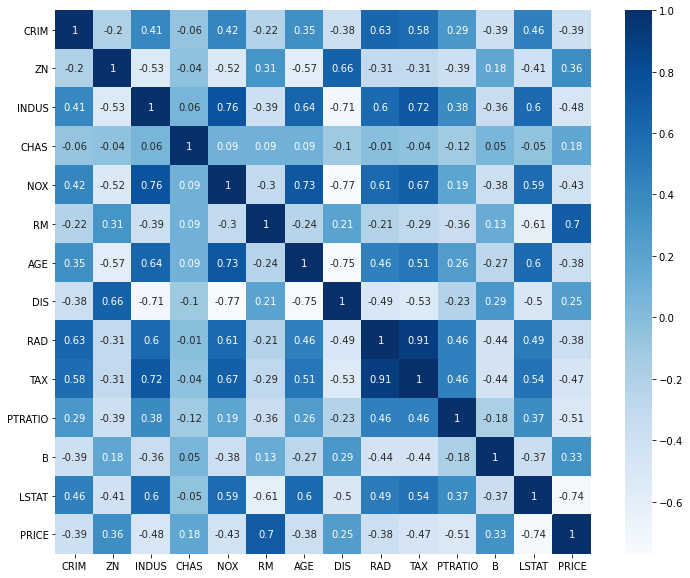

In [6]:
correlation_matrix = df_boston.corr().round(2) # 取到第2位

plt.figure(figsize=(12, 10))
# annot = True 讓我們可以把數字標進每個格子裡
sns.heatmap(data=correlation_matrix, annot=True, cmap="Blues")
plt.show()

In [7]:
# predict
df_feature = df_boston.drop(["PRICE"], axis=1) 

StrategyCompare(df_feature, df_boston["PRICE"])


=== All feature ===
coeff = [-1.19139697e-01  4.76307169e-02  3.11385581e-03  2.51765094e+00
 -1.65965017e+01  3.66544866e+00 -1.13971582e-02 -1.58813261e+00
  2.52228398e-01 -1.08619777e-02 -1.04804097e+00  6.18082895e-03
 -5.19802805e-01]
bias = 40.824
MSE = 26.559
R^2 of training set = 0.768
R^2 of testing set = 0.671 

=== positive-correlation top3 feature ===
coeff = [8.22172109 0.06004983 0.02101779]
bias = -37.369
MSE = 37.053
R^2 of training set = 0.563
R^2 of testing set = 0.540 

=== negative-correlation top3 feature ===
coeff = [-0.01480237 -1.35715576 -0.81732332]
bias = 58.128
MSE = 39.728
R^2 of training set = 0.647
R^2 of testing set = 0.507 

=== F-test top3 feature ===
coeff = [-0.58004584  4.36946009 -1.1288158 ]
bias = 23.236
MSE = 32.436
R^2 of training set = 0.712
R^2 of testing set = 0.598 

=== Mutual info top3 feature ===
coeff = [-0.59790223  5.18958956 -0.10840361]
bias = -1.334
MSE = 32.223
R^2 of training set = 0.656
R^2 of testing set = 0.600 


,MSE,R2_score_train,R2_score_test,Feature
All,26.558582,0.767716,0.67058,All
pos-corr_top3,37.052604,0.563029,0.540417,"[RM, ZN, B]"
neg-corr_top3,39.728324,0.646956,0.507228,"[INDUS, PTRATIO, LSTAT]"
F-test_top3,32.435526,0.711964,0.597685,"[LSTAT, RM, PTRATIO]"
MI_top3,32.222727,0.655599,0.600324,"[LSTAT, RM, INDUS]"


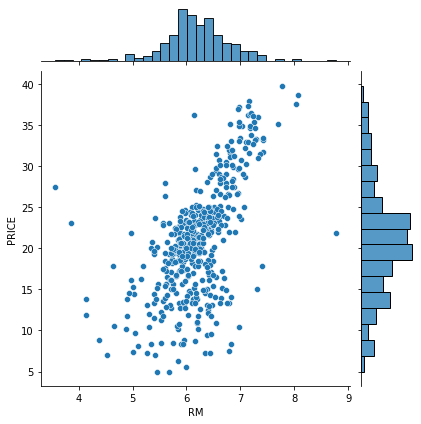

In [18]:
df_boston_removeOutlier = df_boston[df_boston["PRICE"] < 40]
sns.jointplot(x="RM", y="PRICE", data=df_boston_removeOutlier)

In [19]:
# predict
df_feature = df_boston_removeOutlier.drop(["PRICE"], axis=1) 

StrategyCompare(df_feature, df_boston_removeOutlier["PRICE"])


=== All feature ===
coeff = [-9.77435305e-02  4.07159640e-02 -5.35656501e-02  7.64240525e-01
 -1.39380125e+01  1.95487027e+00 -2.17367643e-02 -1.35450356e+00
  2.23904712e-01 -1.09338884e-02 -6.94152194e-01  7.54915446e-03
 -4.05297651e-01]
bias = 41.760
MSE = 11.305
R^2 of training set = 0.774
R^2 of testing set = 0.745 

=== positive-correlation top3 feature ===
coeff = [5.78917188 0.03980144 0.55710034]
bias = -17.301
MSE = 23.396
R^2 of training set = 0.428
R^2 of testing set = 0.472 

=== negative-correlation top3 feature ===
coeff = [-0.00631609 -0.09271676 -0.61037205]
bias = 32.750
MSE = 16.419
R^2 of training set = 0.649
R^2 of testing set = 0.630 

=== F-test top3 feature ===
coeff = [-0.53707012 -0.17029479  2.16611536]
bias = 16.627
MSE = 15.457
R^2 of training set = 0.661
R^2 of testing set = 0.651 

=== Mutual info top3 feature ===
coeff = [-0.59516562 -0.12234286 -0.72479386]
bias = 43.783
MSE = 14.920
R^2 of training set = 0.674
R^2 of testing set = 0.663 


,MSE,R2_score_train,R2_score_test,Feature
All,11.305307,0.774406,0.744985,All
pos-corr_top3,23.395926,0.427632,0.472256,"[RM, ZN, DIS]"
neg-corr_top3,16.418696,0.649259,0.629642,"[TAX, INDUS, LSTAT]"
F-test_top3,15.456919,0.66126,0.651337,"[LSTAT, INDUS, RM]"
MI_top3,14.92046,0.674208,0.663438,"[LSTAT, INDUS, PTRATIO]"
